In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, homogeneity_score, accuracy_score
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import FastICA
from scipy import stats

# Load the dataset
wine_dataset = load_wine()

# Access the feature names
feature_names = wine_dataset.feature_names

# Access the data and target
data = wine_dataset.data
target = wine_dataset.target

# Convert data and target to a Pandas DataFrame
wine_df = pd.DataFrame(data, columns=feature_names)
wine_df['target'] = target

np.random.seed(42)

print(wine_df.info())
print(wine_df.shape)

# Normalize features for better performance
min_max_scaler = MinMaxScaler()
wineX = min_max_scaler.fit_transform(wine_df.drop("target", axis=1).values)
wineY = wine_df["target"].values

# Perform a stratified split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(wineX, wineY, test_size=0.2, stratify=wineY, random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/decompositi

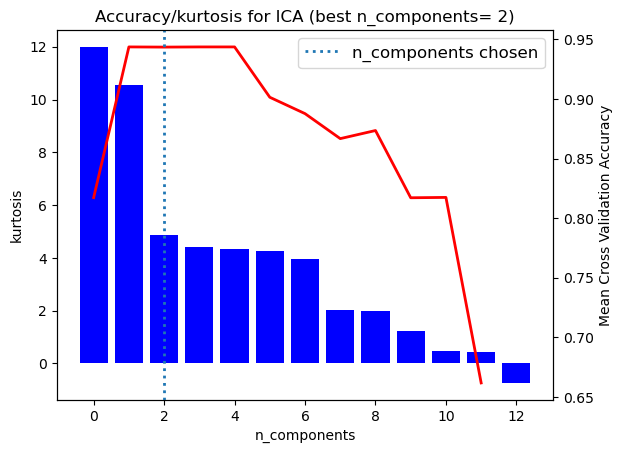

/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


In [2]:
# Initialize the FastICA with random state for reproducibility
ica = FastICA(random_state=42)

# Dimensionality reduction with ICA
def _calculate(X, ica_, n_components):
    components = ica_.components_
    ica_.components_ = components[:n_components]

    transformed = ica_.transform(X)
    ica_.components_ = components

    kurtosis = stats.kurtosis(transformed)

    return sorted(kurtosis, reverse=True)

# Train ICA only on the training set
ica.fit(X_train)

# Plotting Kurtosis to select number of components
fig, ax = plt.subplots()
ax.bar(range(X_train.shape[1]), _calculate(X_train, ica, X_train.shape[1]), linewidth=2, color='blue')
plt.axis('tight')
plt.xlabel('n_components')
ax.set_ylabel('kurtosis')

# Determine the best number of components with GridSearchCV
decisiontree = DecisionTreeClassifier(criterion='gini', max_depth=15, min_samples_split=5)
pipe = Pipeline(steps=[('ica', ica), ('decisionTree', decisiontree)])

# Checking the accuracy for different numbers of components
n_components = range(1, X_train.shape[1])
gridSearch = GridSearchCV(pipe, dict(ica__n_components=n_components), cv=3)
gridSearch.fit(X_train, y_train)
results = gridSearch.cv_results_

# Plotting the accuracies
ax1 = ax.twinx()
ax1.plot(results['mean_test_score'], linewidth=2, color='red')
ax1.set_ylabel('Mean Cross Validation Accuracy')
ax1.axvline(gridSearch.best_estimator_.named_steps['ica'].n_components, linestyle=':', label='n_components chosen', linewidth=2)
plt.legend(prop=dict(size=12))
plt.title('Accuracy/kurtosis for ICA (best n_components= %d)' % gridSearch.best_estimator_.named_steps['ica'].n_components)
plt.show()

# Apply ICA with the optimal number of components
ica_optimal = FastICA(n_components=gridSearch.best_estimator_.named_steps['ica'].n_components, random_state=42)
ica_optimal.fit(X_train)
X_train_ica = ica_optimal.transform(X_train)

# Reconstruction Error Analysis
reconstruction_error = []
for comp in n_components:
    ica_temp = FastICA(n_components=comp, random_state=42)
    X_temp_transformed = ica_temp.fit_transform(X_train)
    X_temp_projected = ica_temp.inverse_transform(X_temp_transformed)
    reconstruction_error.append(mean_squared_error(X_train, X_temp_projected))
    if comp == gridSearch.best_estimator_.named_steps['ica'].n_components:
        chosen_error = mean_squared_error(X_train, X_temp_projected)

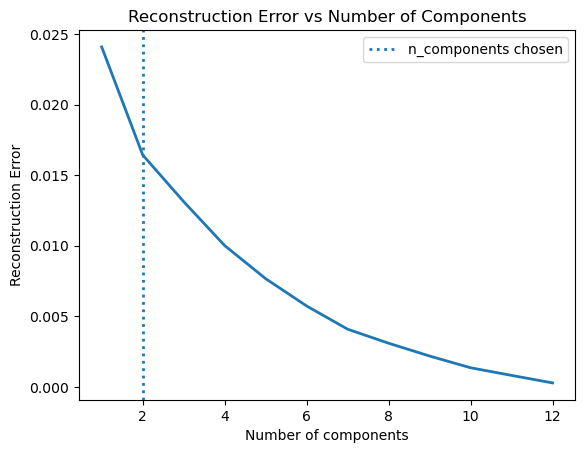

Reconstruction error for chosen n_components (2): 0.016435
Accuracy of Original Data: 0.9722
Accuracy for ICA Transformed Data: 0.9444


In [3]:
# Plotting Reconstruction Error
fig2, ax2 = plt.subplots()
ax2.plot(n_components, reconstruction_error, linewidth=2)
ax2.axvline(gridSearch.best_estimator_.named_steps['ica'].n_components, linestyle=':', label='n_components chosen', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of components')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error vs Number of Components')
plt.legend()
plt.show()

print(f"Reconstruction error for chosen n_components ({gridSearch.best_estimator_.named_steps['ica'].n_components}): {chosen_error:.6f}")

# Training and evaluating a Decision Tree classifier
# Fit the decision tree on the original data
decision_tree_original = DecisionTreeClassifier(criterion='gini', max_depth=15, min_samples_split=5)
decision_tree_original.fit(X_train, y_train)
y_pred_original = decision_tree_original.predict(X_test)
accuracy_original = accuracy_score(y_test, y_pred_original)
print(f'Accuracy of Original Data: {accuracy_original:.4f}')

# Fit the decision tree on the ICA-transformed data
decision_tree_ica = DecisionTreeClassifier(criterion='gini', max_depth=15, min_samples_split=5)
decision_tree_ica.fit(X_train_ica, y_train)
X_test_ica = ica_optimal.transform(X_test)
y_pred_ica = decision_tree_ica.predict(X_test_ica)
accuracy_ica = accuracy_score(y_test, y_pred_ica)
print(f'Accuracy for ICA Transformed Data: {accuracy_ica:.4f}')

In [4]:
#EM on ICA 
from sklearn.mixture import GaussianMixture

# Fit GMM on the ICA-transformed data
gmm = GaussianMixture(n_components=5, random_state=42)
gmm.fit(X_train_ica)

# Predict the clusters on the training data
y_train_gmm = gmm.predict(X_train_ica)

# Predict the clusters on the testing data
X_test_ica = ica_optimal.transform(X_test)
y_test_gmm = gmm.predict(X_test_ica)

# Evaluate the results
print('Silhouette Score:', silhouette_score(X_test_ica, y_test_gmm))
print('Homogeneity Score:', homogeneity_score(y_test, y_test_gmm))

# If you have the true labels for the test set, you can calculate adjusted Rand index or NMI
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

print('Adjusted Rand Index:', adjusted_rand_score(y_test, y_test_gmm))
print('Normalized Mutual Information:', normalized_mutual_info_score(y_test, y_test_gmm))

Silhouette Score: 0.35567122506578625
Homogeneity Score: 0.931063189594503
Adjusted Rand Index: 0.6836344219987541
Normalized Mutual Information: 0.7809247819036851


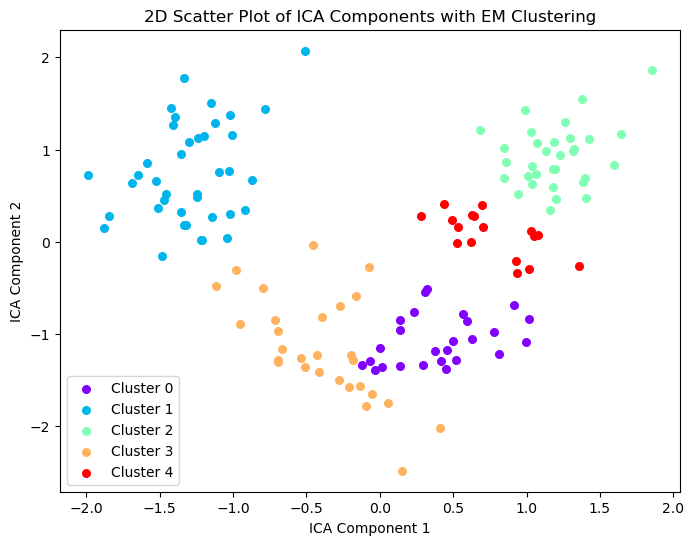

In [5]:
# 2D Scatter plot
plt.figure(figsize=(8, 6))

# Color map for the clusters
colors = cm.rainbow(np.linspace(0, 1, len(set(y_train_gmm))))

# Plot each cluster in 2D
for i, color in zip(range(len(set(y_train_gmm))), colors):
    plt.scatter(X_train_ica[y_train_gmm == i, 0], X_train_ica[y_train_gmm == i, 1], 
                color=color, label=f'Cluster {i}', s=30)

# Title and labels
plt.title('2D Scatter Plot of ICA Components with EM Clustering')
plt.xlabel('ICA Component 1')
plt.ylabel('ICA Component 2')
plt.legend()

# Show plot
plt.show()

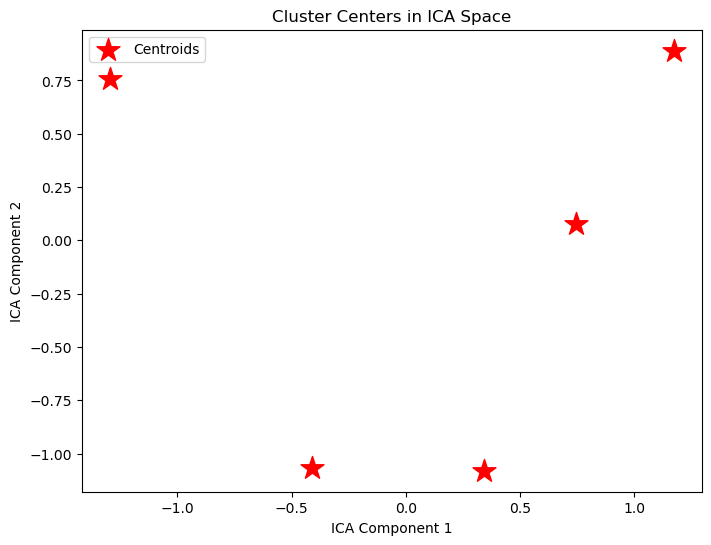

In [6]:
# Fit GMM on the ICA-transformed data
gmm = GaussianMixture(n_components=5, random_state=42)
gmm.fit(X_train_ica)

# Get the cluster centers (means of the Gaussians)
cluster_centers = gmm.means_

# Plot the cluster centers
plt.figure(figsize=(8, 6))
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=300, marker='*', label='Centroids')
plt.title('Cluster Centers in ICA Space')
plt.xlabel('ICA Component 1')
plt.ylabel('ICA Component 2')
plt.legend()
plt.show()

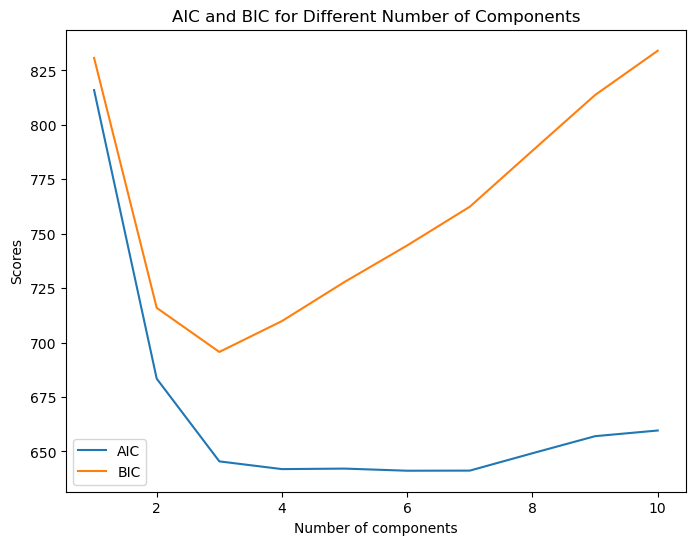

In [6]:
# Calculate the AIC and BIC for a range of n_components
n_components_range = range(1, 11)
aics = []
bics = []
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_train_ica)
    aics.append(gmm.aic(X_train_ica))
    bics.append(gmm.bic(X_train_ica))

# Plot the AIC and BIC
plt.figure(figsize=(8, 6))
plt.plot(n_components_range, aics, label='AIC')
plt.plot(n_components_range, bics, label='BIC')
plt.xlabel('Number of components')
plt.ylabel('Scores')
plt.legend()
plt.title('AIC and BIC for Different Number of Components')
plt.show()

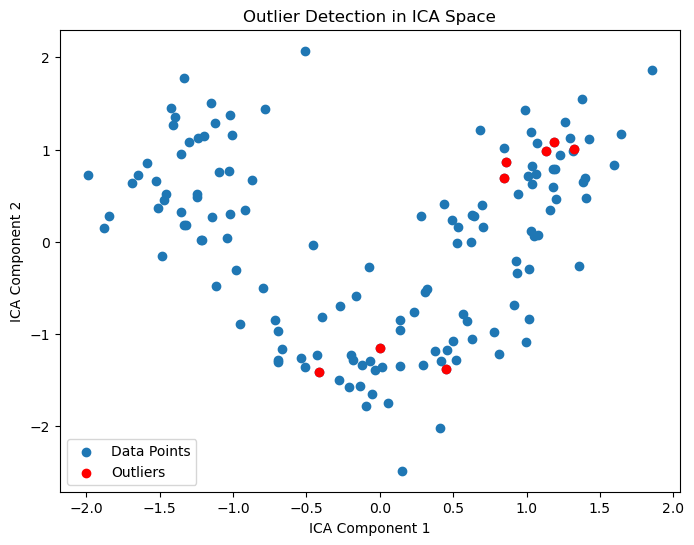

In [7]:
# Get the probability of each point belonging to each cluster
probabilities = gmm.predict_proba(X_train_ica)

# Define a threshold for outliers, for example, the lowest 5% of probabilities
threshold = np.percentile(probabilities.max(axis=1), 5)

# Detect the outliers based on the threshold
outliers = np.where(probabilities.max(axis=1) < threshold)[0]

# Visualize the outliers
plt.figure(figsize=(8, 6))
plt.scatter(X_train_ica[:, 0], X_train_ica[:, 1], label='Data Points')
plt.scatter(X_train_ica[outliers, 0], X_train_ica[outliers, 1], c='red', label='Outliers')
plt.title('Outlier Detection in ICA Space')
plt.xlabel('ICA Component 1')
plt.ylabel('ICA Component 2')
plt.legend()
plt.show()

In [8]:
# Add cluster assignments as features
X_train_with_clusters = np.hstack((X_train_ica, y_train_gmm.reshape(-1, 1)))

# Fit a new decision tree classifier
decision_tree_with_clusters = DecisionTreeClassifier(criterion='gini', max_depth=15, min_samples_split=5)
decision_tree_with_clusters.fit(X_train_with_clusters, y_train)

# Transform test data
X_test_with_clusters = np.hstack((X_test_ica, y_test_gmm.reshape(-1, 1)))

# Predict and evaluate
y_pred_with_clusters = decision_tree_with_clusters.predict(X_test_with_clusters)
accuracy_with_clusters = accuracy_score(y_test, y_pred_with_clusters)
print(f'Accuracy for ICA Transformed Data with Cluster Features: {accuracy_with_clusters:.4f}')

Accuracy for ICA Transformed Data with Cluster Features: 0.9444


In [9]:
#K-Means on ICA

/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default 

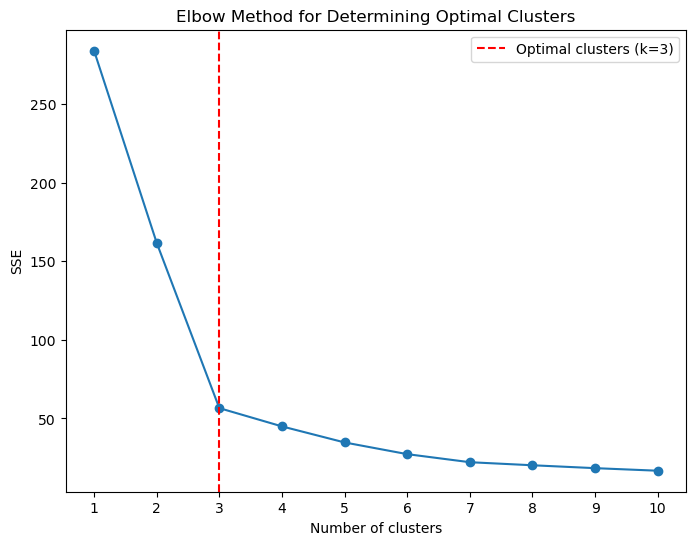

/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


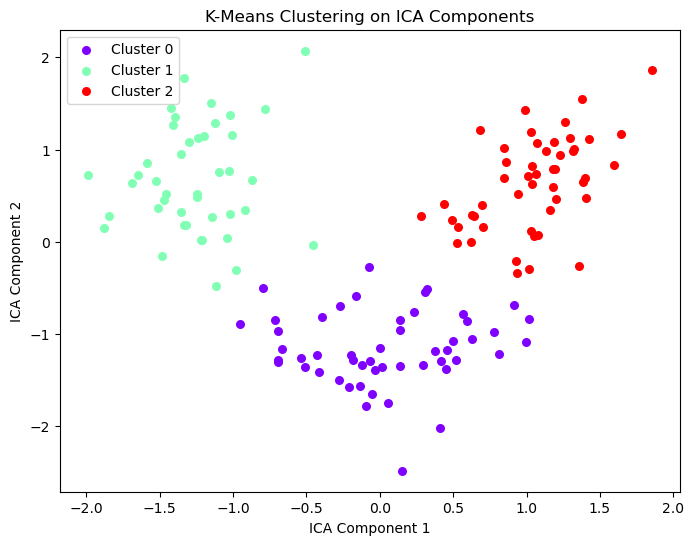

In [10]:
from sklearn.cluster import KMeans

# Determine the SSE for a range of cluster counts
sse = []
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_train_ica)
    sse.append(kmeans.inertia_)  # Inertia: Sum of distances of samples to their closest cluster center

# Plot SSE for each n_clusters
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method for Determining Optimal Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.xticks(range(1, 11))
plt.axvline(x=3, linestyle='--', color='red', label='Optimal clusters (k=3)')
plt.legend()
plt.show()

# Now apply K-Means with the optimal number of clusters (3) to the ICA-transformed data
kmeans_optimal = KMeans(n_clusters=3, random_state=42)
kmeans_optimal.fit(X_train_ica)

# Predict the clusters
y_train_kmeans = kmeans_optimal.predict(X_train_ica)
X_test_ica = ica_optimal.transform(X_test)
y_test_kmeans = kmeans_optimal.predict(X_test_ica)

# Visualize the clusters
plt.figure(figsize=(8, 6))
colors = cm.rainbow(np.linspace(0, 1, len(set(y_train_kmeans))))
for i, color in zip(range(len(set(y_train_kmeans))), colors):
    plt.scatter(X_train_ica[y_train_kmeans == i, 0], X_train_ica[y_train_kmeans == i, 1],
                color=color, label=f'Cluster {i}', s=30)
plt.title('K-Means Clustering on ICA Components')
plt.xlabel('ICA Component 1')
plt.ylabel('ICA Component 2')
plt.legend()
plt.show()

In [11]:
# Silhouette Coefficient
silhouette_avg = silhouette_score(X_train_ica, y_train_kmeans)
print('Silhouette Score:', silhouette_avg)

Silhouette Score: 0.5981979643206844


For n_clusters = 3 The average silhouette_score is : 0.5981979643206844


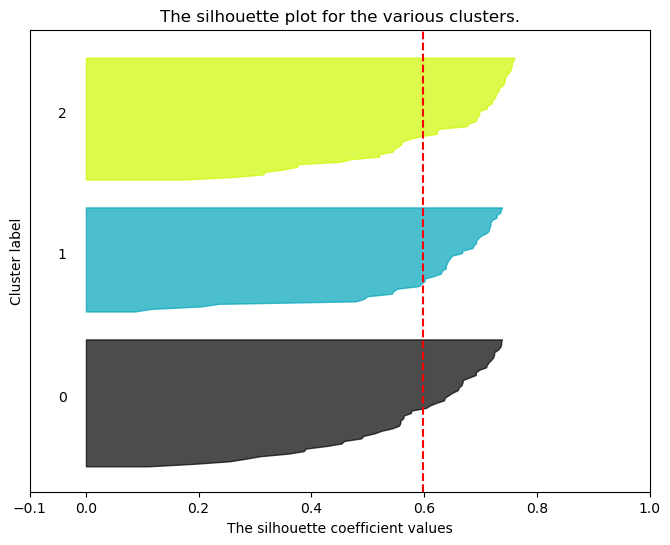

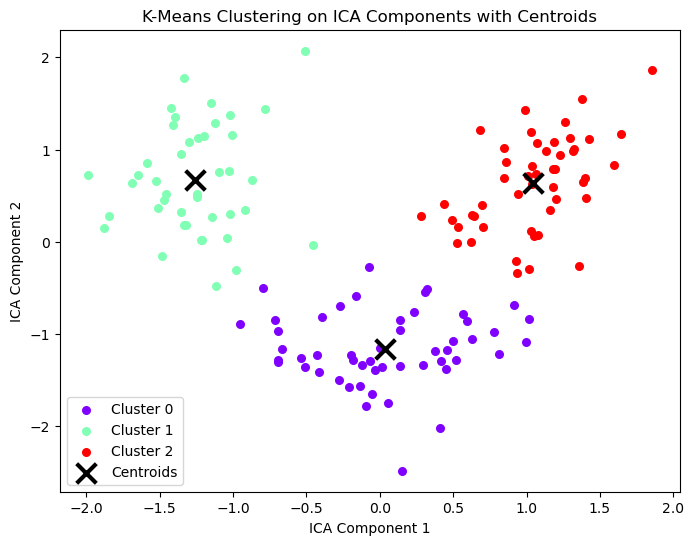

In [14]:
from sklearn.metrics import silhouette_samples
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Silhouette Plot
def silhouette_plot(X, y, n_clusters):
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 6)
    
    # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
    silhouette_avg = silhouette_score(X, y)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, y)
    
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[y == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    plt.show()

silhouette_plot(X_train_ica, y_train_kmeans, 3)

# Visualizing the centroids of the clusters
centroids = kmeans_optimal.cluster_centers_

plt.figure(figsize=(8, 6))
colors = cm.rainbow(np.linspace(0, 1, len(set(y_train_kmeans))))
for i, color in zip(range(len(set(y_train_kmeans))), colors):
    plt.scatter(X_train_ica[y_train_kmeans == i, 0], X_train_ica[y_train_kmeans == i, 1],
                color=color, label=f'Cluster {i}', s=30)
    
# Mark the centroids. This assumes the ICA components are 2-dimensional.
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=200, linewidths=3,
            color='black', zorder=10, label='Centroids')
plt.title('K-Means Clustering on ICA Components with Centroids')
plt.xlabel('ICA Component 1')
plt.ylabel('ICA Component 2')
plt.legend()
plt.show()

In [15]:
#EM clustering after ICA

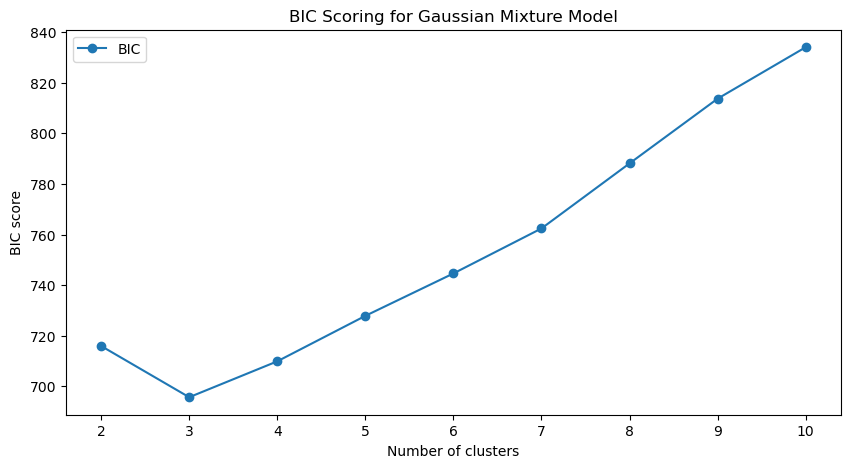

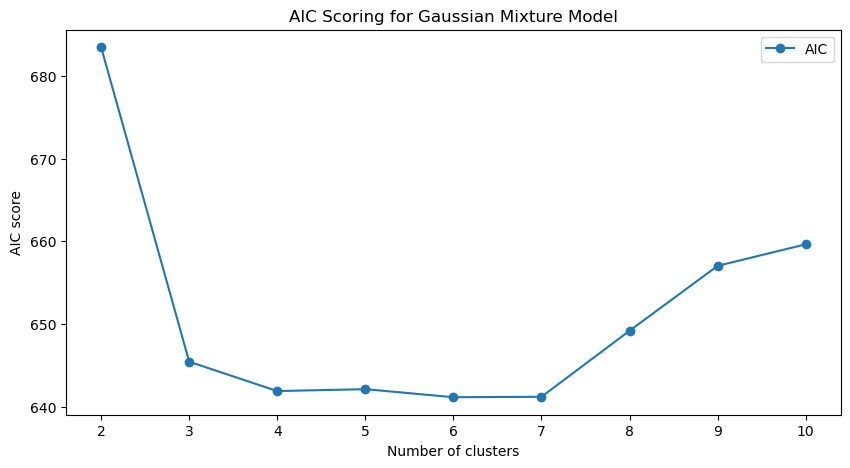

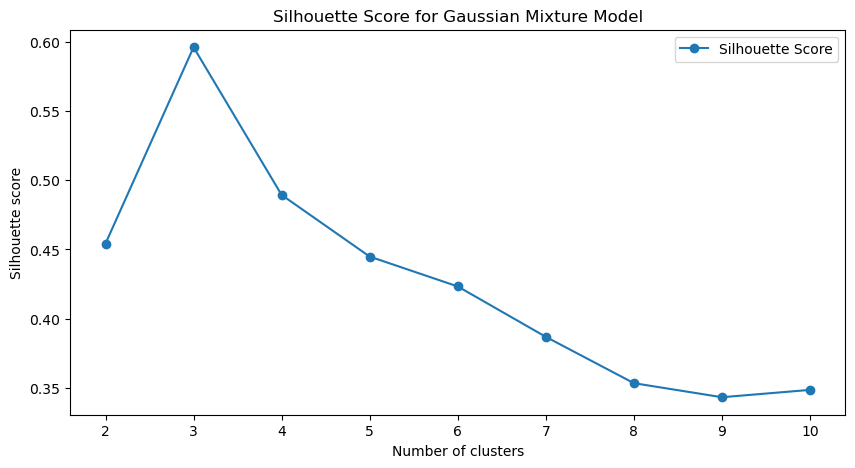

Optimal number of clusters according to BIC: 3
Optimal number of clusters according to Silhouette Score: 3
Optimal number of clusters according to AIC: 6


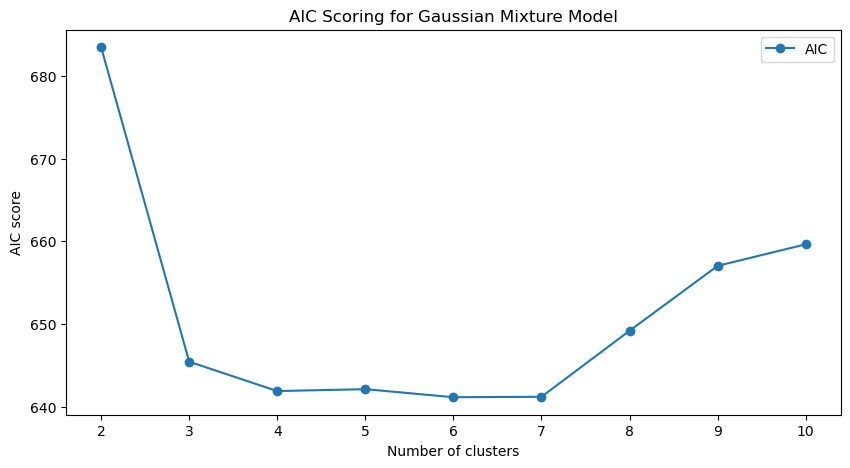

In [8]:
# ... (Your existing code above)

# Gaussian Mixture Model clustering for different numbers of clusters
n_clusters_range = range(2, 11)  # Trying 2 to 10 clusters (at least 2 clusters for silhouette score)
bics = []
aics = []
silhouette_scores = []

for n_clusters in n_clusters_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(X_train_ica)
    labels = gmm.predict(X_train_ica)
    bics.append(gmm.bic(X_train_ica))
    aics.append(gmm.aic(X_train_ica))
    # Compute the silhouette score, which requires at least 2 clusters
    if n_clusters > 1:
        silhouette_scores.append(silhouette_score(X_train_ica, labels))

# Plot the BIC scores
plt.figure(figsize=(10, 5))
plt.plot(n_clusters_range, bics, label='BIC', marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('BIC score')
plt.title('BIC Scoring for Gaussian Mixture Model')
plt.legend()
plt.show()

# Plot the AIC scores
plt.figure(figsize=(10, 5))
plt.plot(n_clusters_range, aics, label='AIC', marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('AIC score')
plt.title('AIC Scoring for Gaussian Mixture Model')
plt.legend()
plt.show()

# Plot the Silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(n_clusters_range, silhouette_scores, label='Silhouette Score', marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette Score for Gaussian Mixture Model')
plt.legend()
plt.show()

# Identifying the optimal number of clusters based on BIC and Silhouette Score
optimal_n_clusters_bic = n_clusters_range[np.argmin(bics)]
optimal_n_clusters_silhouette = n_clusters_range[np.argmax(silhouette_scores)]

print(f'Optimal number of clusters according to BIC: {optimal_n_clusters_bic}')
print(f'Optimal number of clusters according to Silhouette Score: {optimal_n_clusters_silhouette}')
# Identifying the optimal number of clusters based on AIC
optimal_n_clusters_aic = n_clusters_range[np.argmin(aics)]

print(f'Optimal number of clusters according to AIC: {optimal_n_clusters_aic}')

# Plot the AIC scores
plt.figure(figsize=(10, 5))
plt.plot(n_clusters_range, aics, label='AIC', marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('AIC score')
plt.title('AIC Scoring for Gaussian Mixture Model')
plt.legend()
plt.show()

In [9]:
from sklearn.metrics import adjusted_rand_score

# After clustering
labels_true = y_train  # If you have true labels
labels_pred = gmm.predict(X_train_ica)
ARI_score = adjusted_rand_score(labels_true, labels_pred)
print(f'Adjusted Rand Index: {ARI_score}')


Adjusted Rand Index: 0.3440297616454882


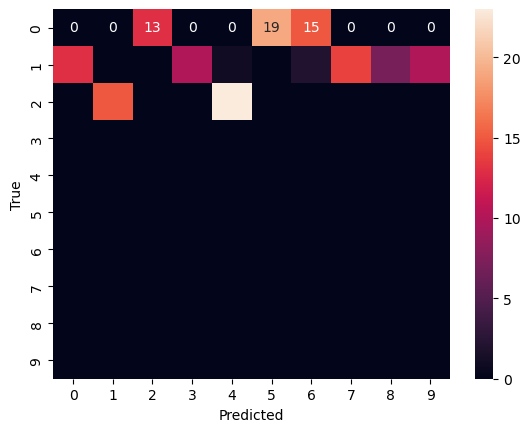

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(labels_true, labels_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


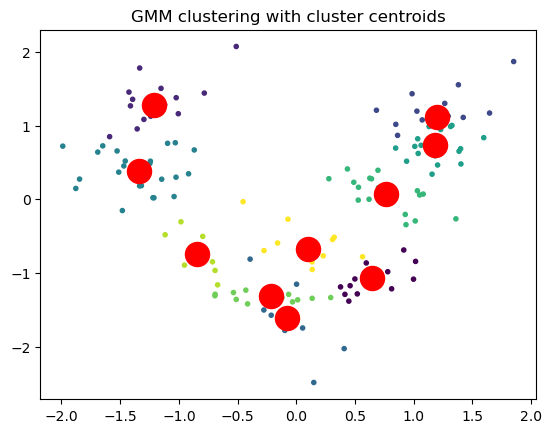

In [11]:
# Assuming you have a 2D dataset or have reduced it to 2D
plt.scatter(X_train_ica[:, 0], X_train_ica[:, 1], c=labels_pred, cmap='viridis', marker='.')
plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], s=300, c='red', marker='o')
plt.title('GMM clustering with cluster centroids')
plt.show()


In [12]:
from sklearn.metrics import calinski_harabasz_score

CH_score = calinski_harabasz_score(X_train_ica, labels_pred)
print(f'Calinski-Harabasz Index: {CH_score}')


Calinski-Harabasz Index: 207.14808307602829


In [13]:
from sklearn.metrics import davies_bouldin_score

DB_score = davies_bouldin_score(X_train_ica, labels_pred)
print(f'Davies-Bouldin Index: {DB_score}')


Davies-Bouldin Index: 1.0342182402483595


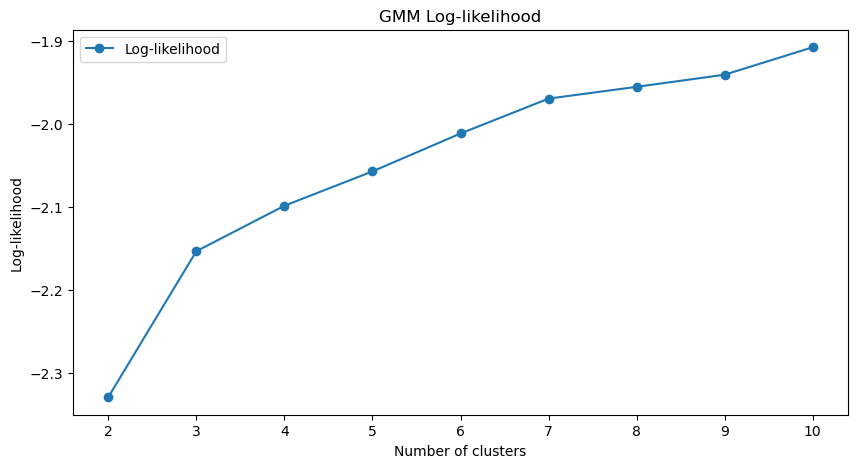

In [14]:
log_likelihoods = [GaussianMixture(n_components=n, random_state=42).fit(X_train_ica).score(X_train_ica) for n in n_clusters_range]
plt.figure(figsize=(10, 5))
plt.plot(n_clusters_range, log_likelihoods, label='Log-likelihood', marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Log-likelihood')
plt.title('GMM Log-likelihood')
plt.legend()
plt.show()

In [15]:
#KMeans

/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default 

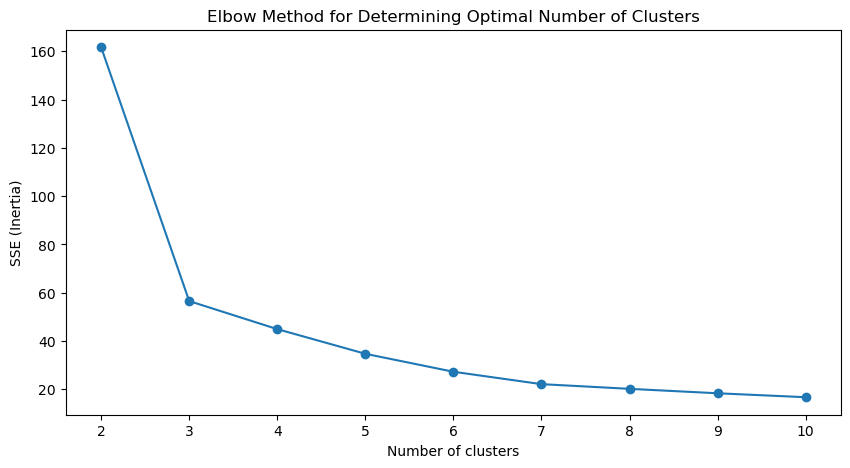

/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Optimal number of clusters (Elbow Method): 2


/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default 

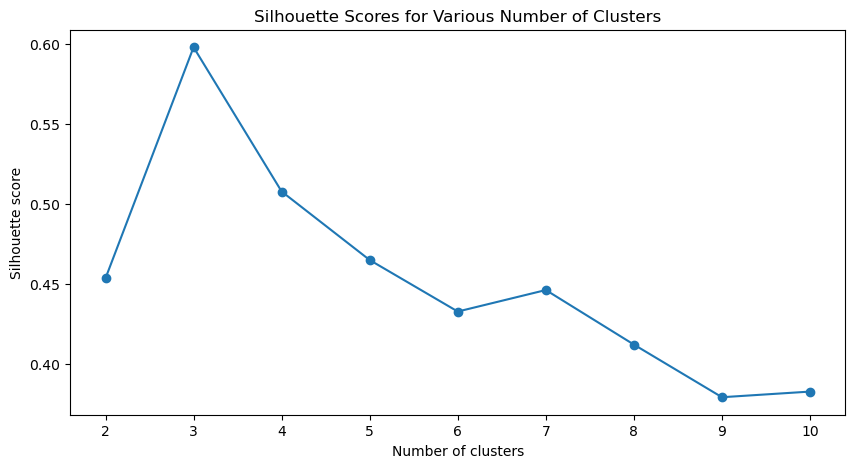

Optimal number of clusters according to Silhouette Score: 3


In [16]:
from sklearn.cluster import KMeans

# Range of clusters to try
n_clusters_range = range(2, 11)

# To store the SSE values for each n_clusters
sse = []
for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_train_ica)
    sse.append(kmeans.inertia_)

# Plotting the SSE values to find the elbow
plt.figure(figsize=(10, 5))
plt.plot(n_clusters_range, sse, marker='o')
plt.title('Elbow Method for Determining Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('SSE (Inertia)')
plt.xticks(n_clusters_range)
plt.show()

# Find the elbow point, which is the point where the SSE starts to flatten out
elbow_point = np.argmin(np.gradient(sse))

print(f'Optimal number of clusters (Elbow Method): {n_clusters_range[elbow_point]}')

# Additionally, you can calculate the silhouette score for each number of clusters
from sklearn.metrics import silhouette_score

silhouette_scores = []
for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X_train_ica)
    silhouette_scores.append(silhouette_score(X_train_ica, labels))

# Plotting the Silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(n_clusters_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Various Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.xticks(n_clusters_range)
plt.show()

optimal_n_clusters_silhouette = n_clusters_range[np.argmax(silhouette_scores)]
print(f'Optimal number of clusters according to Silhouette Score: {optimal_n_clusters_silhouette}')

/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Davies-Bouldin Index: 0.530021459768449
Calinski-Harabasz Index: 279.5067148505449
Adjusted Rand Index: 0.8743140040693659


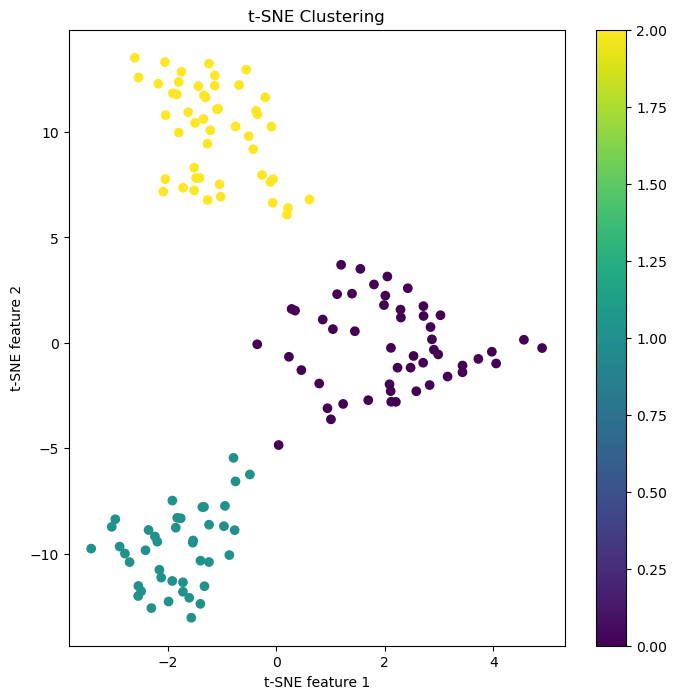

In [17]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score
from sklearn.manifold import TSNE

# Let's say you already have `labels` from your best KMeans model
best_labels = KMeans(n_clusters=optimal_n_clusters_silhouette, random_state=42).fit_predict(X_train_ica)

# Metrics
print(f"Davies-Bouldin Index: {davies_bouldin_score(X_train_ica, best_labels)}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_score(X_train_ica, best_labels)}")

# Adjusted Rand Index (requires true labels)
print(f"Adjusted Rand Index: {adjusted_rand_score(y_train, best_labels)}")

# Visualization with t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_train_ica_tsne = tsne.fit_transform(X_train_ica)

plt.figure(figsize=(8, 8))
plt.scatter(X_train_ica_tsne[:, 0], X_train_ica_tsne[:, 1], c=best_labels)
plt.title("t-SNE Clustering")
plt.xlabel("t-SNE feature 1")
plt.ylabel("t-SNE feature 2")
plt.colorbar()
plt.show()


/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

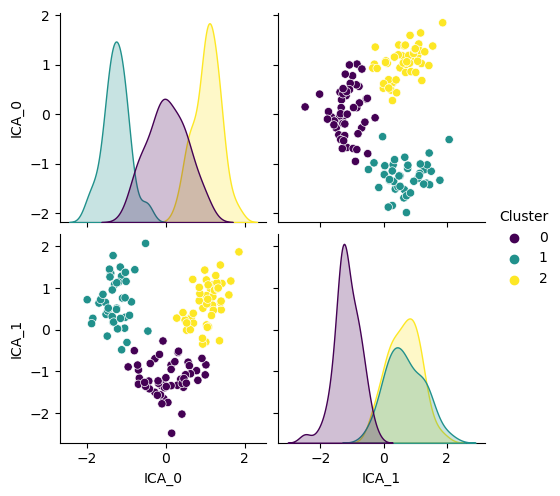

In [18]:
import seaborn as sns
import pandas as pd

# Creating a DataFrame with cluster labels
ica_df = pd.DataFrame(X_train_ica, columns=[f'ICA_{i}' for i in range(X_train_ica.shape[1])])
ica_df['Cluster'] = best_labels

# Pair plot
sns.pairplot(ica_df, hue='Cluster', palette='viridis')
plt.show()

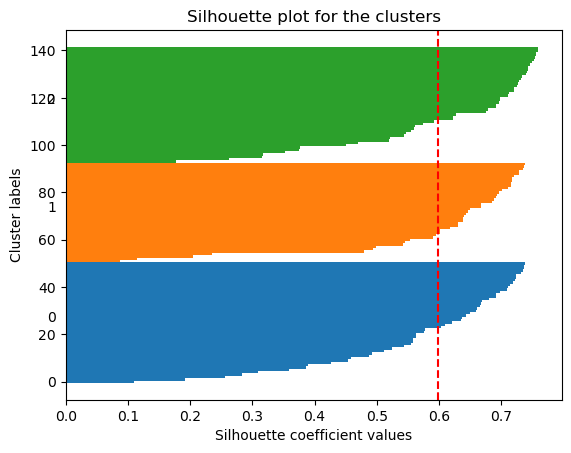

In [20]:
from sklearn.metrics import silhouette_samples

# Compute the silhouette scores for each sample
silhouette_vals = silhouette_samples(X_train_ica, best_labels)

# Silhouette plot
y_ticks = []
y_lower, y_upper = 0, 0
for i, cluster in enumerate(np.unique(best_labels)):
    cluster_silhouette_vals = silhouette_vals[best_labels == cluster]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
    plt.text(-0.03, (y_lower + y_upper) / 2, str(i))
    y_lower += len(cluster_silhouette_vals)

# The vertical line for average silhouette score of all values
avg_score = np.mean(silhouette_vals)
plt.axvline(avg_score, color="red", linestyle="--")
plt.xlabel('Silhouette coefficient values')
plt.ylabel('Cluster labels')
plt.title('Silhouette plot for the clusters')
plt.show()

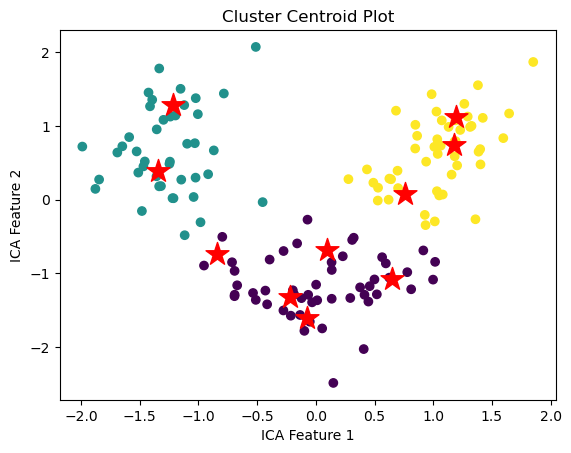

In [21]:
# Assuming `gmm` is your fitted GaussianMixture model
plt.scatter(X_train_ica[:, 0], X_train_ica[:, 1], c=best_labels, cmap='viridis', zorder=2)

# Plot the Gaussian means as centroids
plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], s=300, marker='*', c='red', zorder=3)

plt.title('Cluster Centroid Plot')
plt.xlabel('ICA Feature 1')
plt.ylabel('ICA Feature 2')
plt.show()